In [18]:
import os
import pandas as pd

# Đường dẫn thư mục dữ liệu gốc và thư mục lưu kết quả
input_folder = r"data/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv"
output_folder = r"processed_data"

# Tạo thư mục processed_data nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)
processed_person_count = 0
# Số lượng người: 01 đến 53
for i in range(1, 54):
    full_processed = True

    # Định dạng số với 2 chữ số
    subj_id = f"{i:02d}"
    # Tạo thư mục con cho mỗi người
    subj_folder = os.path.join(output_folder, f"bidmc_{subj_id}")
    os.makedirs(subj_folder, exist_ok=True)
    
    # Đường dẫn file
    signals_file = os.path.join(input_folder, f"bidmc_{subj_id}_Signals.csv")
    numerics_file = os.path.join(input_folder, f"bidmc_{subj_id}_Numerics.csv")
    breaths_file = os.path.join(input_folder, f"bidmc_{subj_id}_Breaths.csv")
    
    # 1. Đọc và trích xuất từ Signals: chỉ lấy cột "Time [s]" và "PLETH"
    if os.path.exists(signals_file):
        df_signals = pd.read_csv(signals_file)
        df_signals.columns = df_signals.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_signals.columns and 'PLETH' in df_signals.columns:
            df_signals = df_signals[['Time [s]', 'PLETH']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Lưu file đã xử lý
        df_signals.to_csv(os.path.join(subj_folder, "Signals_processed.csv"), index=False)
    
    # 2. Đọc và trích xuất từ Numerics: lấy cột "Time [s]", "HR" và "RESP"
    if os.path.exists(numerics_file):
        df_numerics = pd.read_csv(numerics_file)
        df_numerics.columns = df_numerics.columns.str.strip()

        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_numerics.columns and 'HR' in df_numerics.columns and 'RESP' in df_numerics.columns:
            df_numerics = df_numerics[['Time [s]', 'HR', 'RESP']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False

        # Lưu file đã xử lý
        df_numerics.to_csv(os.path.join(subj_folder, "Numerics_processed.csv"), index=False)
    
    # 3. Đọc và trích xuất từ Breath: chọn cột annotator (ví dụ: đặt lại tên thành "ann1", "ann2")
    if os.path.exists(breaths_file):
        df_breaths = pd.read_csv(breaths_file)
        df_breaths.columns = df_breaths.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'breaths ann1 [signal sample no]' in df_breaths.columns and 'breaths ann2 [signal sample no]' in df_breaths.columns:
            # Đổi tên cột cho dễ đọc
            rename_dict = {}
            for col in df_breaths.columns:
                if "ann1" in col.lower():
                    rename_dict[col] = "ann1"
                elif "ann2" in col.lower():
                    rename_dict[col] = "ann2"
            if rename_dict:
                df_breaths.rename(columns=rename_dict, inplace=True)

            df_breaths = df_breaths[['ann1', 'ann2']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_processed = False
        # Giả sử tên cột ban đầu là "breaths ann1 [signal sample no]" và "breaths ann2 [signal sample no]"
        
        # Lưu file đã xử lý
        df_breaths.to_csv(os.path.join(subj_folder, "Breaths_processed.csv"), index=False)
    if not full_processed:
        print(f"Không đúng tên cột hoặc không đủ dữ liệu dữ liệu cho người {subj_id}. Bỏ qua.")
        continue
    processed_person_count += 1

# Thông báo đã xử lý xong một người
print(f"Đã xử lý dữ liệu cho {processed_person_count} người.")

# Sau khi xử lý xong, ta sẽ làm sạch dữ liệu trong các file đã lưu trong thư mục processed_data
print("Bắt đầu làm sạch dữ liệu...")

# Sau khi lưu dữ liệu, ta load lại dữ liệu từ processed_data để xử lý các giá trị null hoặc không hợp lệ
# Ví dụ: điền giá trị bị thiếu (fillna) với phương pháp forward fill, và sau đó loại bỏ nếu vẫn còn null.
def clean_dataframe(df, method='ffill'):
    # Áp dụng forward fill
    # df_clean = df.fillna(method=method)
    if method == 'ffill':
        df_clean = df.ffill()
    elif method == 'bfill':
        df_clean = df.bfill()
    else:
        raise ValueError("Chỉ hỗ trợ 'ffill' hoặc 'bfill'")
    # Nếu vẫn còn null, loại bỏ các dòng chứa null
    df_clean = df_clean.dropna()
    return df_clean

# Duyệt qua từng thư mục con và làm sạch dữ liệu
for subj in os.listdir(output_folder):
    subj_path = os.path.join(output_folder, subj)
    if os.path.isdir(subj_path):
        # Danh sách file đã xử lý trong thư mục của người đó
        for file_name in os.listdir(subj_path):
            if file_name.endswith("_processed.csv"):
                file_path = os.path.join(subj_path, file_name)
                df = pd.read_csv(file_path)
                df_clean = clean_dataframe(df)
                # Lưu lại file sau khi làm sạch (có thể ghi đè file cũ)
                df_clean.to_csv(file_path, index=False)
                
print("Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.")


Đã xử lý dữ liệu cho 53 người.
Bắt đầu làm sạch dữ liệu...
Đã trích xuất và làm sạch dữ liệu vào thư mục 'processed_data'.


## Xem dữ liệu

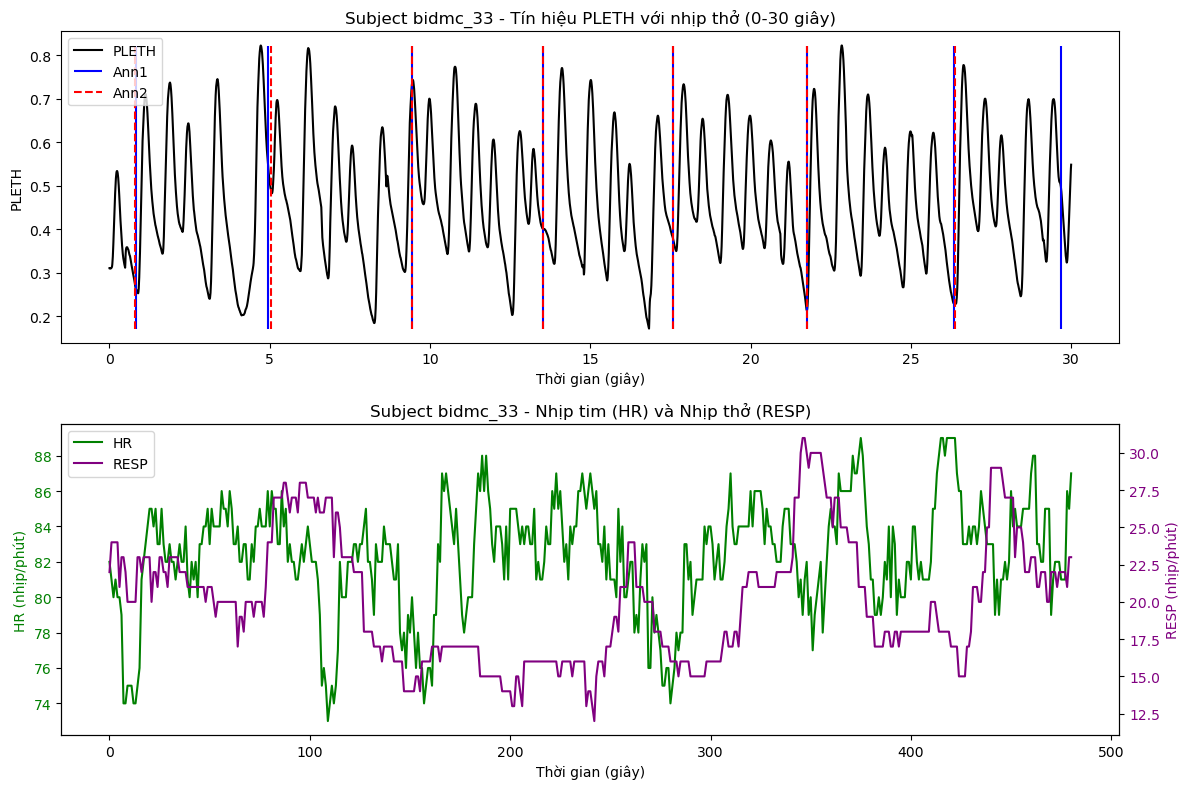

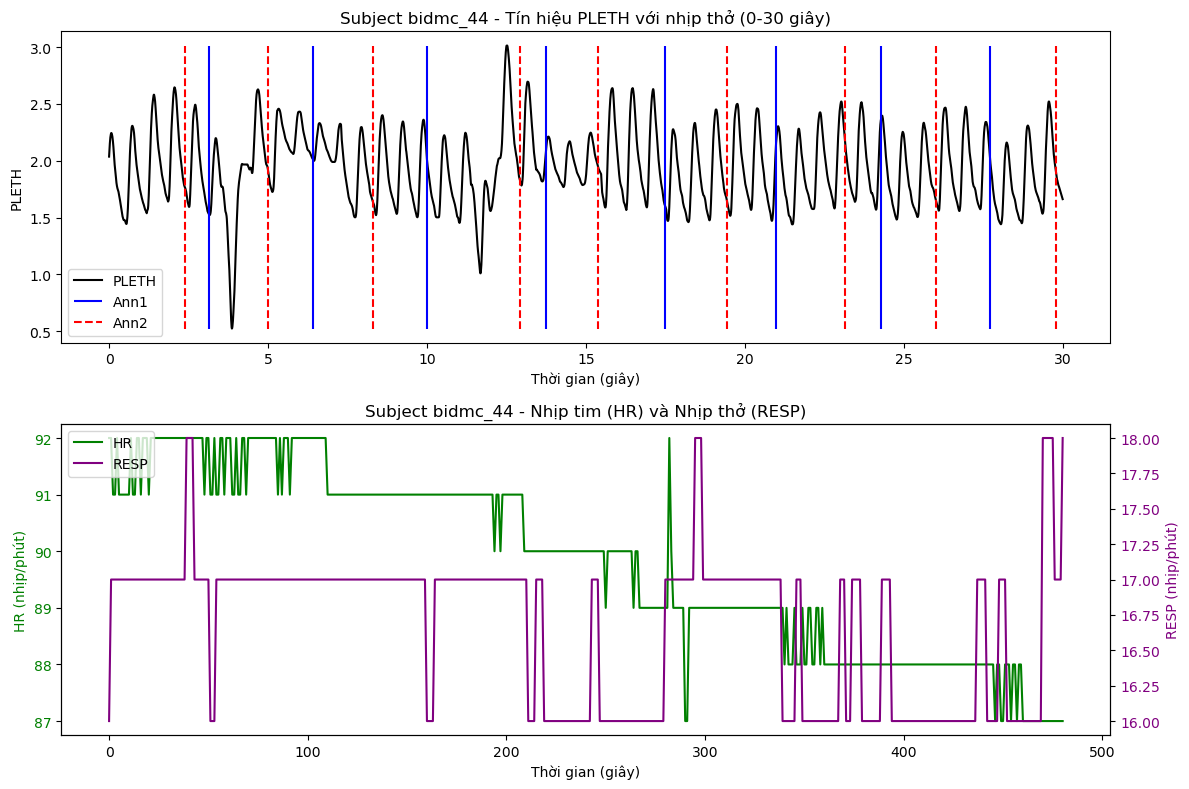

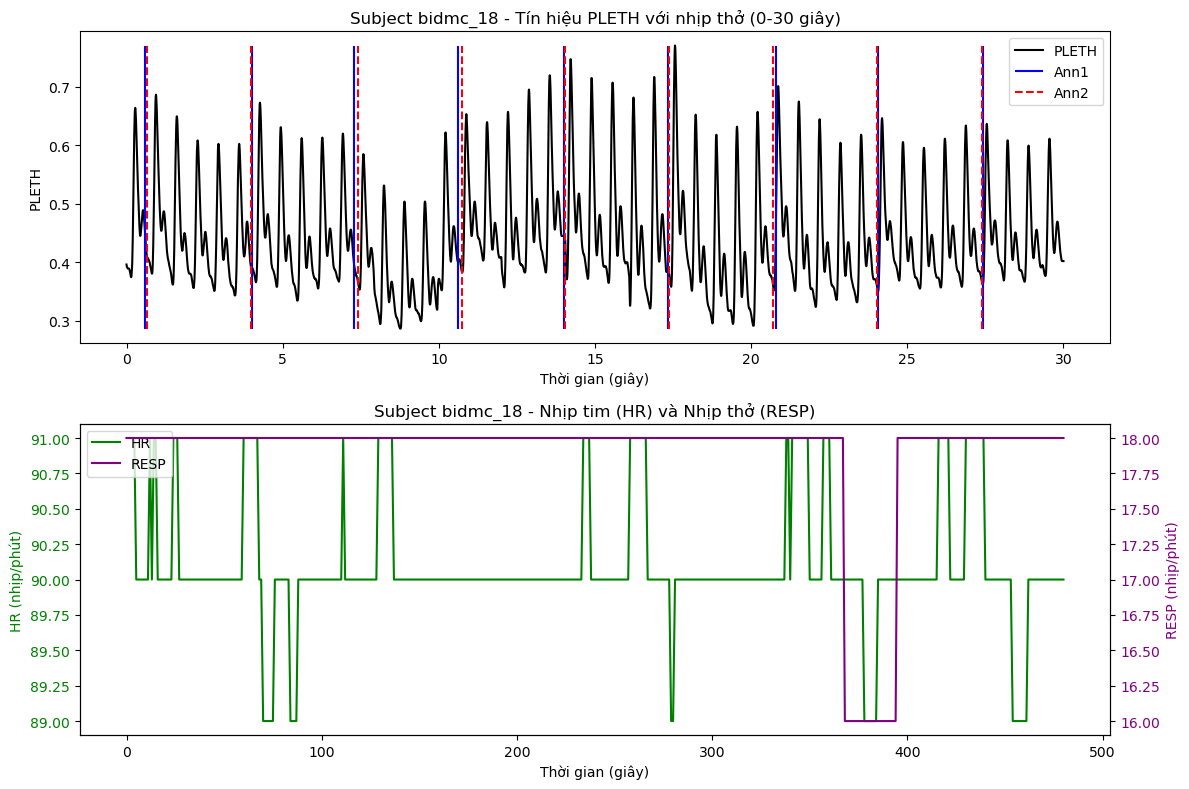

In [19]:
import matplotlib.pyplot as plt
import random

# Đường dẫn đến dữ liệu đã xử lý
base_dir = "processed_data"

# Tạo danh sách các subject IDs từ 01 đến 53
subject_ids = [f"{i:02d}" for i in range(1, 54)]

# Chọn ngẫu nhiên 3 subject
selected_subjects = random.sample(subject_ids, 3)

# Lặp qua từng subject được chọn
for subject in selected_subjects:
    # Tạo đường dẫn đến thư mục của subject
    subject_dir = os.path.join(base_dir, f"bidmc_{subject}")
    
    # Đọc các file CSV
    df_signals = pd.read_csv(os.path.join(subject_dir, 'Signals_processed.csv'))
    df_breaths = pd.read_csv(os.path.join(subject_dir, 'Breaths_processed.csv'))
    df_numerics = pd.read_csv(os.path.join(subject_dir, 'Numerics_processed.csv'))
    
    # Lấy đoạn tín hiệu PLETH từ 0 đến 30 giây
    pleth_segment = df_signals[df_signals['Time [s]'] <= 30]
    
    # Đảm bảo các sample number của breath annotations nằm trong phạm vi tín hiệu
    max_sample = len(df_signals) - 1
    valid_ann1 = df_breaths['ann1'][df_breaths['ann1'] <= max_sample]
    valid_ann2 = df_breaths['ann2'][df_breaths['ann2'] <= max_sample]
    
    # Chuyển sample number thành thời gian và lọc trong khoảng 0-30 giây
    breath_times_ann1 = df_signals['Time [s]'].iloc[valid_ann1]
    breath_times_ann1_segment = breath_times_ann1[breath_times_ann1 <= 30]
    
    breath_times_ann2 = df_signals['Time [s]'].iloc[valid_ann2]
    breath_times_ann2_segment = breath_times_ann2[breath_times_ann2 <= 30]
    
    # Tạo figure với 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Biểu đồ 1: PLETH signal với breath annotations
    ax1.plot(pleth_segment['Time [s]'], pleth_segment['PLETH'], label='PLETH', color='black')
    ax1.vlines(breath_times_ann1_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='blue', linestyles='solid', label='Ann1')
    ax1.vlines(breath_times_ann2_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='red', linestyles='dashed', label='Ann2')
    ax1.set_xlabel('Thời gian (giây)')
    ax1.set_ylabel('PLETH')
    ax1.legend()
    ax1.set_title(f'Subject bidmc_{subject} - Tín hiệu PLETH với nhịp thở (0-30 giây)')
    
    # Biểu đồ 2: HR và RESP
    ax2.plot(df_numerics['Time [s]'], df_numerics['HR'], color='green', label='HR')
    ax2.set_xlabel('Thời gian (giây)')
    ax2.set_ylabel('HR (nhịp/phút)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Tạo trục y thứ hai cho RESP
    ax2_r = ax2.twinx()
    ax2_r.plot(df_numerics['Time [s]'], df_numerics['RESP'], color='purple', label='RESP')
    ax2_r.set_ylabel('RESP (nhịp/phút)', color='purple')
    ax2_r.tick_params(axis='y', labelcolor='purple')
    
    # Thêm legend cho cả HR và RESP
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_r.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    ax2.set_title(f'Subject bidmc_{subject} - Nhịp tim (HR) và Nhịp thở (RESP)')
    
    # Điều chỉnh layout để tránh overlap
    plt.tight_layout()

# Hiển thị tất cả các biểu đồ
plt.show()

## Gộp dữ liệu

In [20]:
# Gộp dữ liệu 
import pandas as pd
import os

# Đường dẫn đến thư mục chứa dữ liệu
base_dir = 'processed_data'

# Danh sách các thư mục từ bidmc_01 đến bidmc_53
subject_ids = [f"{i:02d}" for i in range(1, 54)]

# Khởi tạo danh sách để lưu trữ dữ liệu
all_signals = []
all_numerics = []
all_breaths = []

# Lặp qua từng người
for subject in subject_ids:
    subject_dir = os.path.join(base_dir, f"bidmc_{subject}")
    
    # Đường dẫn đến các file
    signals_file = os.path.join(subject_dir, 'Signals_processed.csv')
    numerics_file = os.path.join(subject_dir, 'Numerics_processed.csv')
    breaths_file = os.path.join(subject_dir, 'Breaths_processed.csv')
    
    # Đọc và thêm cột subject_id nếu file tồn tại
    if os.path.exists(signals_file):
        signals_data = pd.read_csv(signals_file)
        signals_data['subject_id'] = subject
        all_signals.append(signals_data)
    else:
        print(f"Signals file not found for subject {subject}")
    
    if os.path.exists(numerics_file):
        numerics_data = pd.read_csv(numerics_file)
        numerics_data['subject_id'] = subject
        all_numerics.append(numerics_data)
    else:
        print(f"Numerics file not found for subject {subject}")
    
    if os.path.exists(breaths_file):
        breaths_data = pd.read_csv(breaths_file)
        breaths_data['subject_id'] = subject
        all_breaths.append(breaths_data)
    else:
        print(f"Breaths file not found for subject {subject}")

# Gộp dữ liệu thành 3 file lớn
all_signals_df = pd.concat(all_signals, ignore_index=True)
all_numerics_df = pd.concat(all_numerics, ignore_index=True)
all_breaths_df = pd.concat(all_breaths, ignore_index=True) if all_breaths else None

# Lưu thành 3 file CSV
all_signals_df.to_csv('all_signals.csv', index=False)
all_numerics_df.to_csv('all_numerics.csv', index=False)
if all_breaths_df is not None:
    all_breaths_df.to_csv('all_breaths.csv', index=False)

print("Đã gộp dữ liệu thành công vào 'all_signals.csv', 'all_numerics.csv', và (nếu có) 'all_breaths.csv'.")

Đã gộp dữ liệu thành công vào 'all_signals.csv', 'all_numerics.csv', và (nếu có) 'all_breaths.csv'.


## Lọc nhiễu PPG

In [22]:
# # Lấy tín hiệu PPG của một người (ví dụ: bidmc_01)
# subject_id = '01'
# ppg_signal = all_signals_df[all_signals_df['subject_id'] == subject_id]['PLETH'].values

# # Áp dụng lọc bandpass
# ppg_filtered = bandpass_filter(ppg_signal)

# # Vẽ biểu đồ so sánh (tùy chọn)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.plot(ppg_signal[:1000], label='PPG gốc', alpha=0.7)
# plt.plot(ppg_filtered[:1000], label='PPG sau lọc', alpha=0.7)
# plt.title(f'So sánh PPG trước và sau lọc bandpass (Subject {subject_id})')
# plt.xlabel('Mẫu (Sample)')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()

## Phân đoạn và chuẩn hóa

Numerics DataFrame - Before:
Original rows: 25493
After removing outliers: 22145

HR Statistics:
count    22145.000000
mean        88.451389
std         11.125771
min         60.000000
25%         82.000000
50%         89.000000
75%         94.000000
max        116.000000
Name: HR, dtype: float64

RESP Statistics:
count    22145.000000
mean        17.732671
std          2.326022
min         12.000000
25%         16.000000
50%         18.000000
75%         19.000000
max         23.000000
Name: RESP, dtype: float64

Signals DataFrame - Before:
Original rows: 3180053
After removing outliers: 3180053

Original PLETH Statistics:
count    3.180053e+06
mean     6.962972e-01
std      5.804839e-01
min      0.000000e+00
25%      3.831900e-01
50%      4.828900e-01
75%      6.520000e-01
max      4.002000e+00
Name: PLETH, dtype: float64

Filtered PLETH Statistics:
count    3.180053e+06
mean    -2.168067e-05
std      2.416582e-01
min     -2.964344e+00
25%     -1.001958e-01
50%     -3.108775e-02
75% 

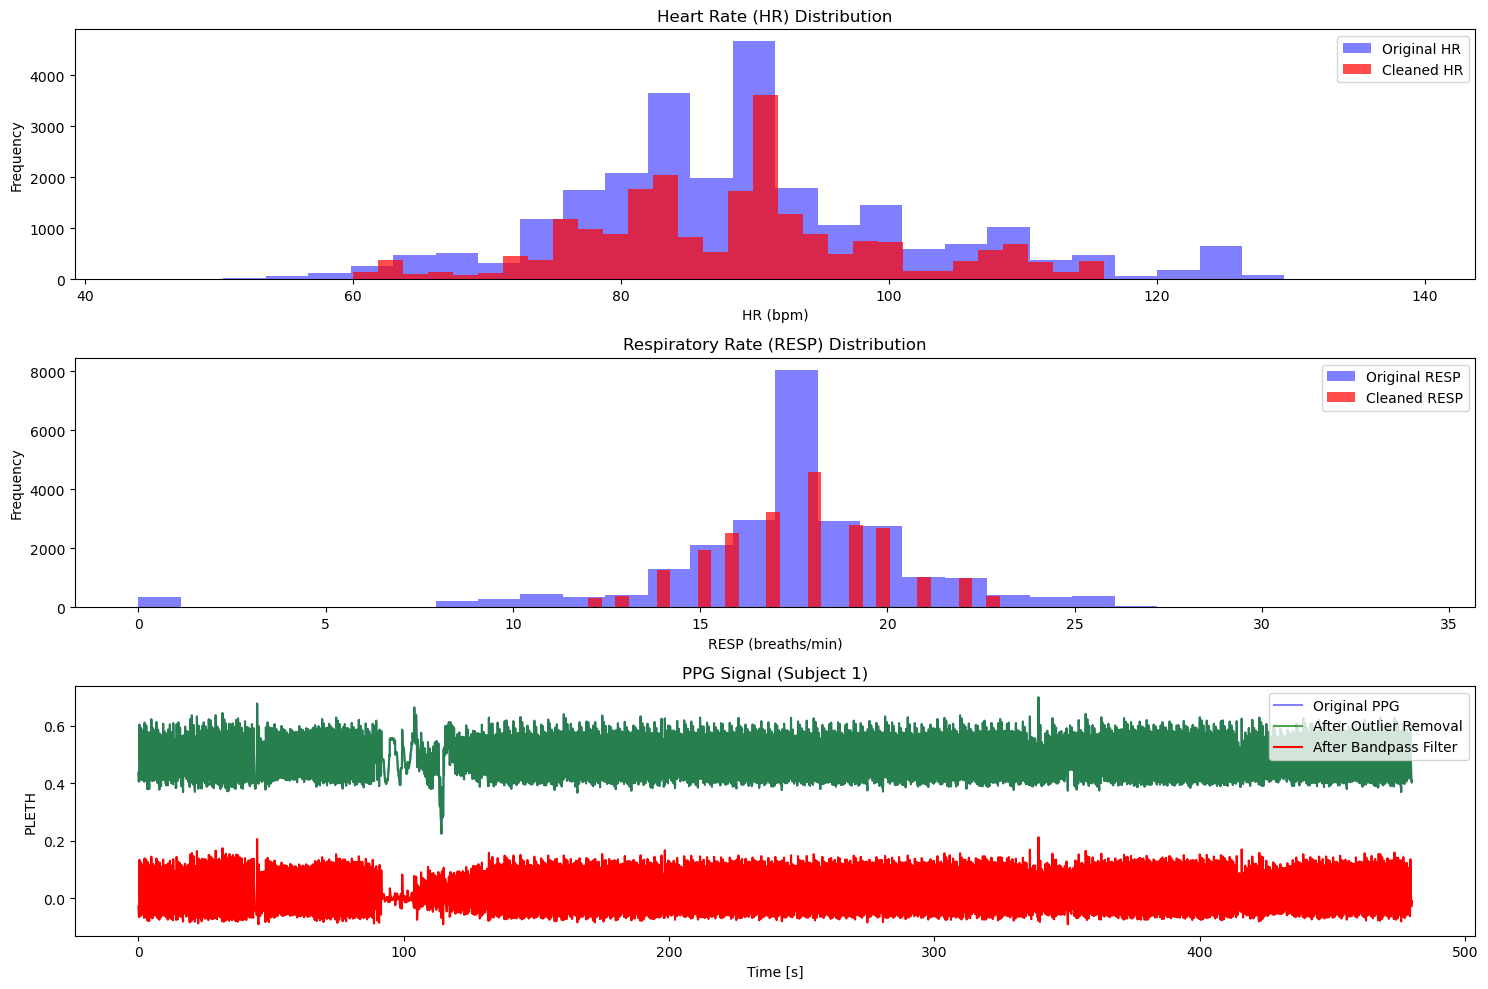

In [24]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1. Đọc dữ liệu
numerics_df = pd.read_csv('all_numerics.csv')  # HR, RESP (1 Hz)
signals_df = pd.read_csv('all_signals.csv')    # PLETH (125 Hz)

# 2. Hàm phát hiện và loại bỏ ngoại lai sử dụng IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

# 3. Xử lý tập numerics_df (HR và RESP)
numerics_clean_hr = remove_outliers(numerics_df, 'HR')
numerics_clean = remove_outliers(numerics_clean_hr, 'RESP')

# 4. Xử lý tập signals_df (PLETH) - Loại bỏ ngoại lai
# signals_clean = remove_outliers(signals_df, 'PLETH')
signals_clean = signals_df.copy()

# 5. Thiết kế bộ lọc thông dải cho PPG
def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=125.0, order=2):
    nyq = 0.5 * fs  # Tần số Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')  # Tạo bộ lọc bandpass
    return filtfilt(b, a, signal)  # Áp dụng lọc


# 7. Áp dụng lọc PPG cho từng subject_id trên dữ liệu đã loại ngoại lai
subjects = signals_clean['subject_id'].unique()
filtered_data = []

for subject in subjects:
    subject_data = signals_clean[signals_clean['subject_id'] == subject]
    ppg_signal = subject_data['PLETH'].values
    ppg_filtered = bandpass_filter(ppg_signal)
    
    subject_filtered = subject_data[['Time [s]', 'subject_id']].copy()
    subject_filtered['PLETH_filtered'] = ppg_filtered
    filtered_data.append(subject_filtered)

signals_filtered = pd.concat(filtered_data, ignore_index=True)

# 8. In thông tin trước và sau khi xử lý
print("Numerics DataFrame - Before:")
print(f"Original rows: {len(numerics_df)}")
print(f"After removing outliers: {len(numerics_clean)}")
print("\nHR Statistics:")
print(numerics_clean['HR'].describe())
print("\nRESP Statistics:")
print(numerics_clean['RESP'].describe())

print("\nSignals DataFrame - Before:")
print(f"Original rows: {len(signals_df)}")
print(f"After removing outliers: {len(signals_clean)}")
print("\nOriginal PLETH Statistics:")
print(signals_clean['PLETH'].describe())
print("\nFiltered PLETH Statistics:")
print(signals_filtered['PLETH_filtered'].describe())

# 9. Vẽ dữ liệu trước và sau khi xử lý
plt.figure(figsize=(15, 10))

# HR - Histogram
plt.subplot(3, 1, 1)
plt.hist(numerics_df['HR'], bins=30, alpha=0.5, label='Original HR', color='blue')
plt.hist(numerics_clean['HR'], bins=30, alpha=0.7, label='Cleaned HR', color='red')
plt.title('Heart Rate (HR) Distribution')
plt.xlabel('HR (bpm)')
plt.ylabel('Frequency')
plt.legend()

# RESP - Histogram
plt.subplot(3, 1, 2)
plt.hist(numerics_df['RESP'], bins=30, alpha=0.5, label='Original RESP', color='blue')
plt.hist(numerics_clean['RESP'], bins=30, alpha=0.7, label='Cleaned RESP', color='red')
plt.title('Respiratory Rate (RESP) Distribution')
plt.xlabel('RESP (breaths/min)')
plt.ylabel('Frequency')
plt.legend()

# PLETH - Biểu đồ đường (chỉ vẽ cho subject đầu tiên)
subject_id = subjects[0]
original_ppg = signals_df[signals_df['subject_id'] == subject_id]['PLETH']
cleaned_ppg = signals_clean[signals_clean['subject_id'] == subject_id]['PLETH']
filtered_ppg = signals_filtered[signals_filtered['subject_id'] == subject_id]['PLETH_filtered']
time_ppg = signals_df[signals_df['subject_id'] == subject_id]['Time [s]']

plt.subplot(3, 1, 3)
plt.plot(time_ppg, original_ppg, 'b-', label='Original PPG', alpha=0.5)
plt.plot(time_ppg.iloc[:len(cleaned_ppg)], cleaned_ppg, 'g-', label='After Outlier Removal', alpha=0.7)
plt.plot(time_ppg.iloc[:len(filtered_ppg)], filtered_ppg, 'r-', label='After Bandpass Filter')
plt.title(f'PPG Signal (Subject {subject_id})')
plt.xlabel('Time [s]')
plt.ylabel('PLETH')
plt.legend()

plt.tight_layout()
plt.show()

## Chuẩn hóa

C:\Users\nguye\AppData\Local\Temp\ipykernel_11972\3985712403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics_clean[['HR_normalized', 'RESP_normalized']] = minmax_scaler.fit_transform(numerics_clean[['HR', 'RESP']])
C:\Users\nguye\AppData\Local\Temp\ipykernel_11972\3985712403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics_clean[['HR_normalized', 'RESP_normalized']] = minmax_scaler.fit_transform(numerics_clean[['HR', 'RESP']])



HR Normalized Statistics:
count    22145.000000
mean         0.508061
std          0.198674
min          0.000000
25%          0.392857
50%          0.517857
75%          0.607143
max          1.000000
Name: HR_normalized, dtype: float64

RESP Normalized Statistics:
count    22145.000000
mean         0.521152
std          0.211457
min          0.000000
25%          0.363636
50%          0.545455
75%          0.636364
max          1.000000
Name: RESP_normalized, dtype: float64

PLETH Normalized Statistics:
count    3.180053e+06
mean     7.803551e-19
std      8.152224e-02
min     -1.000000e+00
25%     -3.379326e-02
50%     -1.047999e-02
75%      3.107962e-02
max      8.594885e-01
Name: PLETH_normalized, dtype: float64


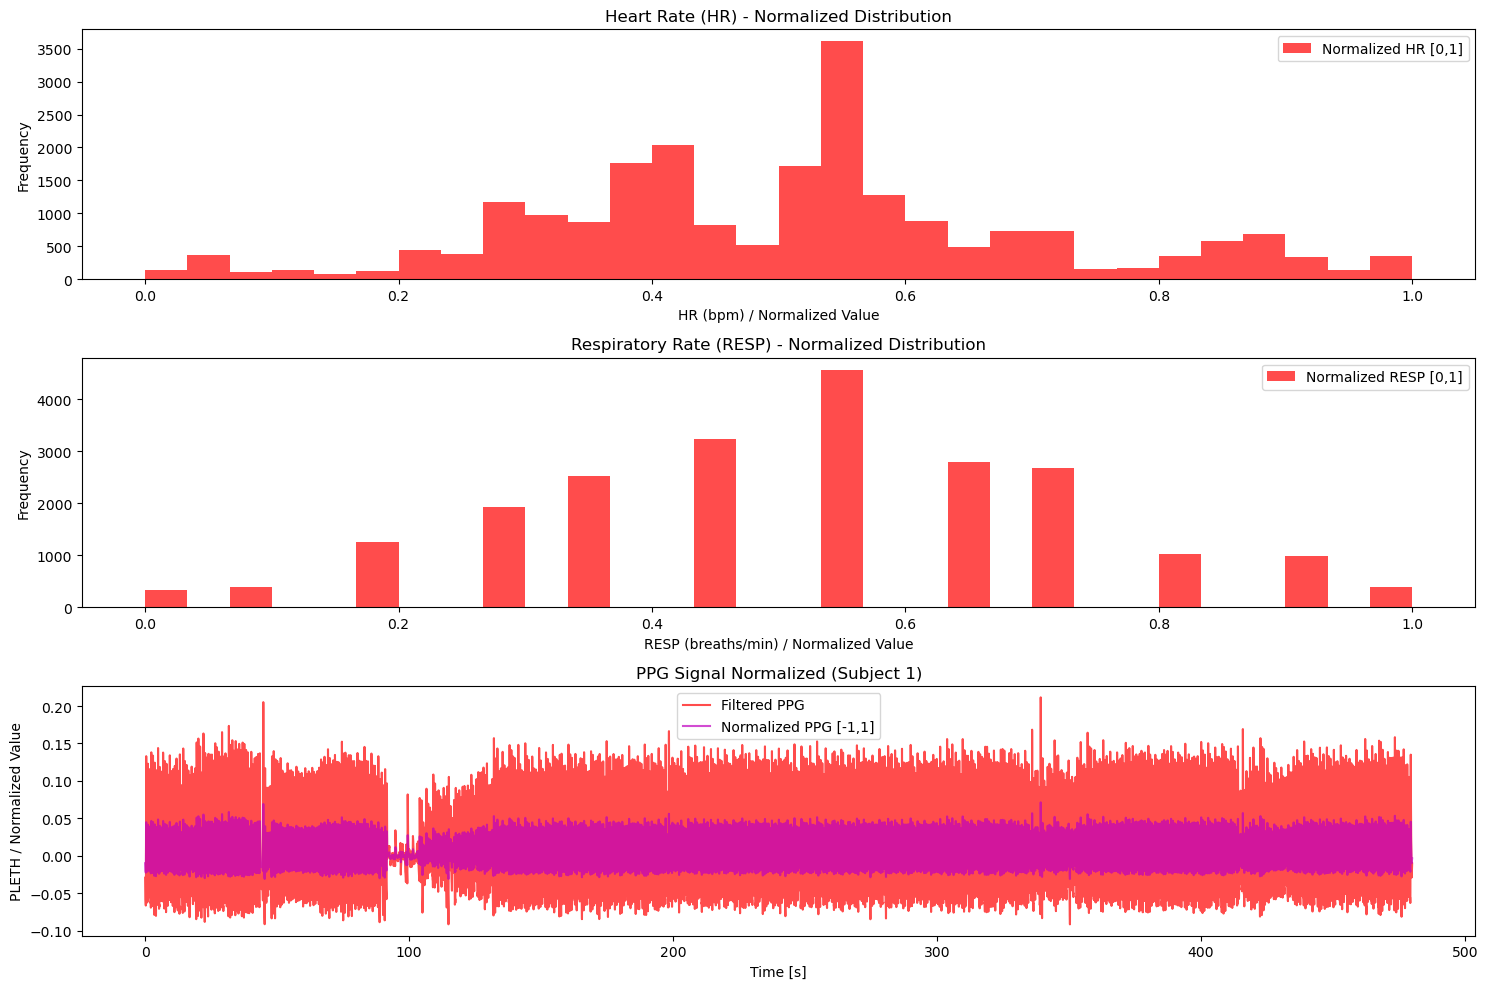

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 1. Chuẩn hóa dữ liệu
# PLETH: Z-score chuẩn hóa và điều chỉnh về [-1, 1]
z_scaler = StandardScaler()
signals_filtered['PLETH_normalized'] = z_scaler.fit_transform(signals_filtered[['PLETH_filtered']])
pleth_max = signals_filtered['PLETH_normalized'].abs().max()
signals_filtered['PLETH_normalized'] = signals_filtered['PLETH_normalized'] * (1 / pleth_max)

# HR và RESP: MinMax Scaling về [0, 1]
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
numerics_clean[['HR_normalized', 'RESP_normalized']] = minmax_scaler.fit_transform(numerics_clean[['HR', 'RESP']])

# 2. In thông tin dữ liệu đã chuẩn hóa
print("\nHR Normalized Statistics:")
print(numerics_clean['HR_normalized'].describe())
print("\nRESP Normalized Statistics:")
print(numerics_clean['RESP_normalized'].describe())
print("\nPLETH Normalized Statistics:")
print(signals_filtered['PLETH_normalized'].describe())

# 3. Vẽ dữ liệu đã chuẩn hóa
plt.figure(figsize=(15, 10))

# HR - Histogram
plt.subplot(3, 1, 1)
# plt.hist(numerics_clean['HR'], bins=30, alpha=0.5, label='Cleaned HR', color='blue')
plt.hist(numerics_clean['HR_normalized'], bins=30, alpha=0.7, label='Normalized HR [0,1]', color='red')
plt.title('Heart Rate (HR) - Normalized Distribution')
plt.xlabel('HR (bpm) / Normalized Value')
plt.ylabel('Frequency')
plt.legend()

# RESP - Histogram
plt.subplot(3, 1, 2)
# plt.hist(numerics_clean['RESP'], bins=30, alpha=0.5, label='Cleaned RESP', color='blue')
plt.hist(numerics_clean['RESP_normalized'], bins=30, alpha=0.7, label='Normalized RESP [0,1]', color='red')
plt.title('Respiratory Rate (RESP) - Normalized Distribution')
plt.xlabel('RESP (breaths/min) / Normalized Value')
plt.ylabel('Frequency')
plt.legend()

# PLETH - Biểu đồ đường (chỉ vẽ cho subject đầu tiên)
subject_id = subjects[0]
filtered_ppg = signals_filtered[signals_filtered['subject_id'] == subject_id]['PLETH_filtered']
normalized_ppg = signals_filtered[signals_filtered['subject_id'] == subject_id]['PLETH_normalized']
time_ppg = signals_filtered[signals_filtered['subject_id'] == subject_id]['Time [s]']

plt.subplot(3, 1, 3)
plt.plot(time_ppg, filtered_ppg, 'r-', label='Filtered PPG', alpha=0.7)
plt.plot(time_ppg, normalized_ppg, 'm-', label='Normalized PPG [-1,1]', alpha=0.7)
plt.title(f'PPG Signal Normalized (Subject {subject_id})')
plt.xlabel('Time [s]')
plt.ylabel('PLETH / Normalized Value')
plt.legend()

plt.tight_layout()
plt.show()

# Chưa lưu file theo yêu cầu của bạn
# Nếu muốn lưu sau này:
numerics_clean.to_csv('numerics_clean.csv', index=False)
signals_filtered.to_csv('signals_filtered.csv', index=False)

In [26]:
import pandas as pd
import numpy as np

# Giả sử dữ liệu đã được xử lý từ các bước trước
# numerics_clean và signals_filtered đã có từ quy trình tiền xử lý
# Lấy dữ liệu đã chuẩn hóa
normalize_hr = numerics_clean['HR_normalized'].values  # 1 Hz
normalize_resp = numerics_clean['RESP_normalized'].values  # 1 Hz
normalized_ppg = signals_filtered['PLETH_normalized'].values  # 125 Hz
time_ppg = signals_filtered['Time [s]'].values  # Thời gian của PPG
time_numerics = numerics_clean['Time [s]'].values  # Thời gian của HR, RESP

# Số giây cho mỗi đoạn
segment_seconds = 10
ppg_segment_length = 125 * segment_seconds  # 125 Hz * 10 giây = 1250 mẫu
numerics_segment_length = 1 * segment_seconds  # 1 Hz * 10 giây = 10 mẫu

# Khởi tạo danh sách chứa các đoạn
all_ppg_segments = []
all_hr_segments = []
all_resp_segments = []

# Tính số đoạn có thể tạo từ dữ liệu
total_samples_ppg = len(normalized_ppg)
total_samples_numerics = len(normalize_hr)
num_segments = min(total_samples_ppg // ppg_segment_length, total_samples_numerics // numerics_segment_length)

# Chia dữ liệu thành các đoạn
for i in range(num_segments):
    # Chỉ số bắt đầu và kết thúc cho mỗi đoạn
    start_idx_ppg = i * ppg_segment_length
    end_idx_ppg = start_idx_ppg + ppg_segment_length
    start_idx_numerics = i * numerics_segment_length
    end_idx_numerics = start_idx_numerics + numerics_segment_length
    
    # Lấy đoạn dữ liệu
    ppg_segment = normalized_ppg[start_idx_ppg:end_idx_ppg]
    hr_segment = normalize_hr[start_idx_numerics:end_idx_numerics]
    resp_segment = normalize_resp[start_idx_numerics:end_idx_numerics]
    
    # Kiểm tra độ dài đoạn (đảm bảo đủ mẫu)
    if len(ppg_segment) == ppg_segment_length and len(hr_segment) == numerics_segment_length:
        all_ppg_segments.append(ppg_segment)
        all_hr_segments.append(hr_segment)
        all_resp_segments.append(resp_segment)

# Chuyển thành mảng numpy
ppg_segments_normalized = np.array(all_ppg_segments)  # Shape: (num_segments, 1250)
hr_segments_normalized = np.array(all_hr_segments)    # Shape: (num_segments, 10)
resp_segments_normalized = np.array(all_resp_segments)  # Shape: (num_segments, 10)

# Tính trung bình HR và RESP trên mỗi đoạn (10 giây) -> shape: (num_segments,)
avg_hr = np.mean(hr_segments_normalized, axis=1)
avg_resp = np.mean(resp_segments_normalized, axis=1)

# Gộp trung bình của HR và RESP thành conditions, với shape: (num_segments, 2)
conditions_normalized = np.stack((avg_hr, avg_resp), axis=-1)

# In thông tin tổng quát
print(f"Total PPG segments: {ppg_segments_normalized.shape[0]}")
print(f"PPG segment shape: {ppg_segments_normalized.shape[1]} samples")
print(f"Total HR segments: {hr_segments_normalized.shape[0]}")
print(f"HR segment shape: {hr_segments_normalized.shape[1]} samples")
print(f"Total RESP segments: {resp_segments_normalized.shape[0]}")
print(f"RESP segment shape: {resp_segments_normalized.shape[1]} samples")
print(f"Total conditions: {conditions_normalized.shape[0]}")
print(f"Conditions shape: {conditions_normalized.shape}")

# Kiểm tra một đoạn mẫu (ví dụ đoạn đầu tiên)
print("\nSample PPG segment (first 5 values):", ppg_segments_normalized[0][:5])
print("Sample HR segment:", hr_segments_normalized[0])
print("Sample RESP segment:", resp_segments_normalized[0])
print("Sample conditions (avg HR, avg RESP):", conditions_normalized[0])


Total PPG segments: 2214
PPG segment shape: 1250 samples
Total HR segments: 2214
HR segment shape: 10 samples
Total RESP segments: 2214
RESP segment shape: 10 samples
Total conditions: 2214
Conditions shape: (2214, 2)

Sample PPG segment (first 5 values): [-0.00981891 -0.011076   -0.01229559 -0.01344223 -0.0144887 ]
Sample HR segment: [0.57142857 0.57142857 0.57142857 0.57142857 0.625      0.625
 0.57142857 0.57142857 0.57142857 0.57142857]
Sample RESP segment: [1.         1.         1.         1.         1.         1.
 0.90909091 0.90909091 0.90909091 0.90909091]
Sample conditions (avg HR, avg RESP): [0.58214286 0.96363636]


---

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, C_train, C_test = train_test_split(ppg_segments_normalized, conditions_normalized, test_size=0.2, random_state=42)

print(X_train.shape, C_train.shape)  # Kiểm tra kích thước dữ liệu huấn luyện
print(X_test.shape, C_test.shape)  # Kiểm tra kích thước dữ liệu kiểm tra

(1771, 1250) (1771, 2)
(443, 1250) (443, 2)


## Kiến trúc model và hàm loss

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        
        # CNN layers đơn giản
        self.conv1 = nn.Conv1d(1, 16, 7, stride=2, padding=3)  # (1250 -> 625)
        self.conv2 = nn.Conv1d(16, 32, 5, stride=2, padding=2)  # (625 -> 313)
        self.conv3 = nn.Conv1d(32, 64, 3, stride=2, padding=1)  # (313 -> 157)
        
        # Tính toán kích thước sau CNN
        self.flatten_size = 64 * 157  # 64 channels * 157 timesteps
        
        # Phần FC gọn hơn
        self.fc = nn.Linear(self.flatten_size + condition_dim, 128)
        
        # Latent space
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, condition):
        # Reshape và CNN
        x = x.view(-1, 1, self.input_dim)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Kết hợp condition
        x = x.view(x.size(0), -1)
        x = torch.cat([x, condition], dim=1)
        
        # FC và latent
        x = F.relu(self.fc(x))
        return self.fc_mean(x), self.fc_logvar(x)

In [29]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, condition_dim=2, output_dim=1250):
        super(Decoder, self).__init__()
        # Phần mở rộng
        self.fc = nn.Linear(latent_dim + condition_dim, 64 * 157)
        
        # Transposed CNN
        self.deconv1 = nn.ConvTranspose1d(64, 32, 3, stride=2, padding=1)  # (157 -> 313)
        self.deconv2 = nn.ConvTranspose1d(32, 16, 5, stride=2, padding=2)  # (313 -> 625)
        self.deconv3 = nn.ConvTranspose1d(16, 1, 7, stride=2, padding=3, output_padding=1)  # (625 -> 1250)

    def forward(self, z, condition):
        # Kết hợp và mở rộng
        x = torch.cat([z, condition], dim=1)
        x = self.fc(x).view(-1, 64, 157)
        
        # Transposed CNN
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        
        return x.view(-1, 1250)

In [30]:
class CVAE(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, condition):
        mean, logvar = self.encoder(x, condition)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z, condition)
        return x_recon, mean, logvar

In [31]:
def loss_function(x_recon, x, mean, logvar, beta=2):
    mse = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + beta * kl, mse, kl, beta

## Train model

Epoch 10, Train Loss: 1.3295, MSE: 1.3295, KL: 153.7340, Beta: 0.0000
Epoch 10, Test Loss: 1.5015, MSE: 1.5015, KL: 156.7756
Epoch 20, Train Loss: 4.1413, MSE: 3.1027, KL: 4.1543, Beta: 0.2500
Epoch 20, Test Loss: 4.8299, MSE: 3.9189, KL: 3.6436
Epoch 30, Train Loss: 4.5718, MSE: 3.4268, KL: 2.2899, Beta: 0.5000
Epoch 30, Test Loss: 4.9157, MSE: 3.8209, KL: 2.1897
Epoch 40, Train Loss: 4.7913, MSE: 3.5597, KL: 1.6421, Beta: 0.7500
Epoch 40, Test Loss: 5.8042, MSE: 4.3300, KL: 1.9656
Epoch 50, Train Loss: 5.0098, MSE: 3.7127, KL: 1.2971, Beta: 1.0000
Epoch 50, Test Loss: 5.6230, MSE: 4.2902, KL: 1.3328
Epoch 60, Train Loss: 4.8030, MSE: 3.5757, KL: 1.2273, Beta: 1.0000
Epoch 60, Test Loss: 5.4637, MSE: 4.1328, KL: 1.3309
Early stopping triggered!


C:\Users\nguye\AppData\Local\Temp\ipykernel_11972\1347656692.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae_loaded.load_state_dict(torch.load(best_model_path))


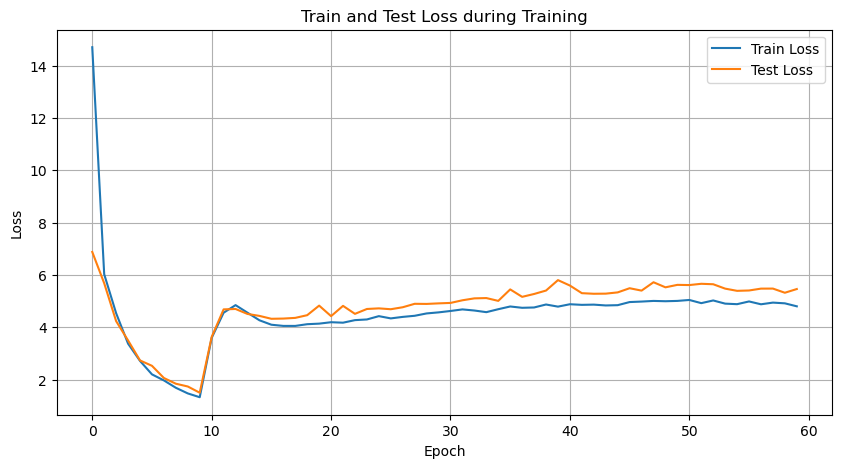

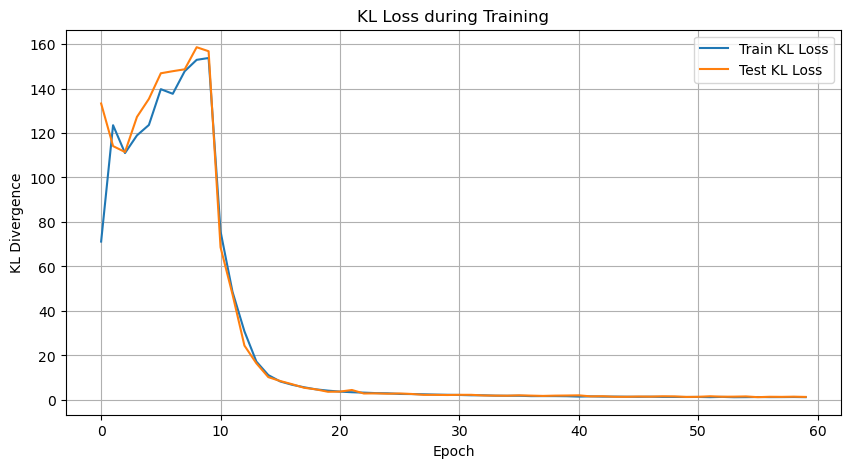

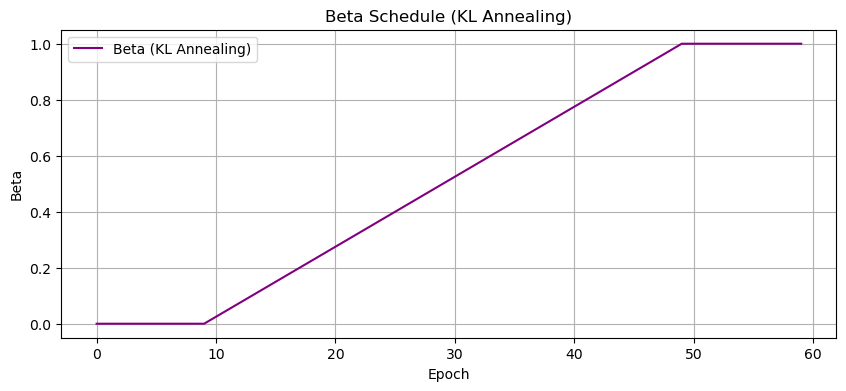

In [32]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import matplotlib.pyplot as plt

# Giả sử X_train, C_train, X_test, C_test đã được định nghĩa
# Chuyển thành tensor
X_train_tensor = torch.FloatTensor(X_train)
C_train_tensor = torch.FloatTensor(C_train)
X_test_tensor = torch.FloatTensor(X_test)
C_test_tensor = torch.FloatTensor(C_test)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, C_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, C_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Khởi tạo mô hình và optimizer
latent_dim = 32
cvae = CVAE(input_dim=ppg_segment_length, condition_dim=2, latent_dim=latent_dim)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Danh sách lưu loss
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_path = 'best_cvae_model.pth'

train_kl_losses = []
test_kl_losses = []
beta_history = []


# Cài đặt cho KL annealing
num_epochs = 500
warmup_epochs = 10      # Số epoch warm-up (beta = 0 trong giai đoạn warm-up)
anneal_duration = 50    # Số epoch tăng beta từ 0 đến 1 sau warm-up
patience = 50
no_improve = 0

for epoch in range(num_epochs):
    # Tính beta dựa trên KL annealing với warm-up
    if epoch < warmup_epochs:
        beta_val = 0.0
    else:
        beta_val = min(1.0, (epoch - warmup_epochs + 1) / anneal_duration)
    beta_history.append(beta_val)
    
    # Huấn luyện trên tập train
    cvae.train()
    total_train_loss = 0
    total_train_kl_loss = 0
    total_train_mse_loss = 0
    
    for x, condition in train_loader:
        x_recon, mean, logvar = cvae(x, condition)
        # Giả sử loss_function trả về (loss, mse, kl, beta) 
        loss, mse, kl, beta_out = loss_function(x_recon, x, mean, logvar, beta=beta_val)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        total_train_kl_loss += kl.item()
        total_train_mse_loss += mse.item()
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
    avg_train_mse_loss = total_train_mse_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_kl_losses.append(avg_train_kl_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse_loss:.4f}, KL: {avg_train_kl_loss:.4f}, Beta: {beta_val:.4f}")
    
    # Đánh giá trên tập test
    cvae.eval()
    total_test_loss = 0
    total_test_kl_loss = 0
    total_test_mse_loss = 0
    with torch.no_grad():
        for x, condition in test_loader:
            x_recon, mean, logvar = cvae(x, condition)
            loss, mse, kl, beta_out = loss_function(x_recon, x, mean, logvar, beta=beta_val)
            total_test_loss += loss.item()
            total_test_kl_loss += kl.item()
            total_test_mse_loss += mse.item()
    
    avg_test_loss = total_test_loss / len(test_loader.dataset)
    avg_test_kl_loss = total_test_kl_loss / len(test_loader.dataset)
    avg_test_mse_loss = total_test_mse_loss / len(test_loader.dataset)

    test_losses.append(avg_test_loss)
    test_kl_losses.append(avg_test_kl_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}, MSE: {avg_test_mse_loss:.4f}, KL: {avg_test_kl_loss:.4f}")
    
    # Lưu mô hình tốt nhất dựa trên test loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(cvae.state_dict(), best_model_path)
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print("Early stopping triggered!")
        break

    # if (epoch + 1) % 10 == 0:
    #     print(f"--- Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Đọc lại mô hình tốt nhất
cvae_loaded = CVAE(input_dim=ppg_segment_length, condition_dim=2, latent_dim=latent_dim)
cvae_loaded.load_state_dict(torch.load(best_model_path))
cvae_loaded.eval()

# Trực quan hóa loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ KL Loss
plt.figure(figsize=(10, 5))
plt.plot(train_kl_losses, label='Train KL Loss')
plt.plot(test_kl_losses, label='Test KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('KL Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ Beta theo thời gian
plt.figure(figsize=(10, 4))
plt.plot(beta_history, label='Beta (KL Annealing)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Beta')
plt.title('Beta Schedule (KL Annealing)')
plt.grid(True)
plt.legend()
plt.show()



torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([27, 32])
z_all.shape: (443, 32)
hr_all.shape: (443,)
resp_all.shape: (443,)


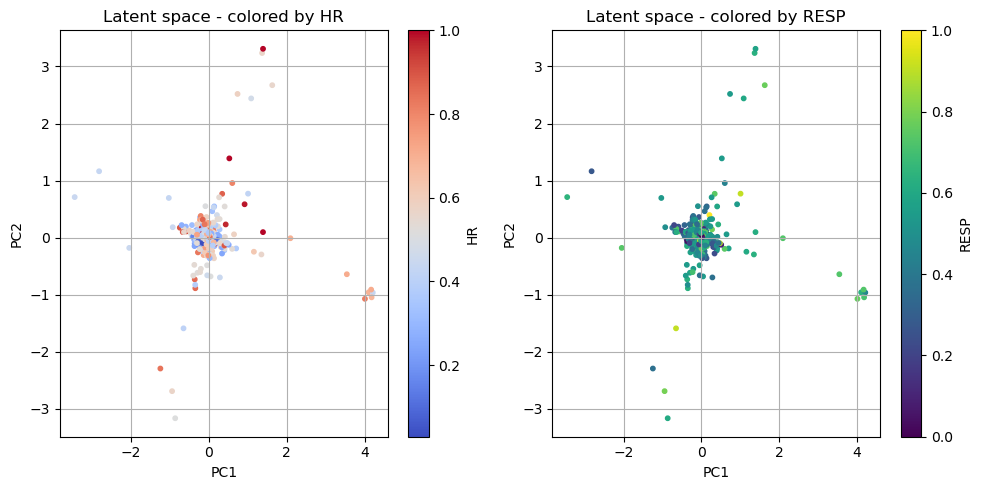

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Đặt mô hình ở chế độ eval
cvae_loaded.eval()

# Tạo danh sách để lưu latent vectors và nhãn (HR, RESP)
z_list = []
hr_list = []
resp_list = []

# Duyệt qua tập test và thu thập mean (z) từ encoder
with torch.no_grad():
    for x, condition in test_loader:
        _, mean, _ = cvae_loaded(x, condition)
        z_list.append(mean)
        print(mean.shape)
        hr_list.append(condition[:, 0])     # HR
        resp_list.append(condition[:, 1])   # RESP

# Ghép lại thành tensor
z_all = torch.cat(z_list, dim=0).cpu().numpy()
hr_all = torch.cat(hr_list, dim=0).cpu().numpy()
resp_all = torch.cat(resp_list, dim=0).cpu().numpy()

# Dùng PCA để giảm từ latent_dim về 2D
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

# Vẽ scatter plot, tô màu theo HR hoặc RESP
plt.figure(figsize=(10, 5))

# Màu theo HR
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=hr_all, cmap='coolwarm', s=10)
plt.colorbar(label='HR')
plt.title('Latent space - colored by HR')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Màu theo RESP
plt.subplot(1, 2, 2)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=resp_all, cmap='viridis', s=10)
plt.colorbar(label='RESP')
plt.title('Latent space - colored by RESP')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

plt.tight_layout()
plt.show()


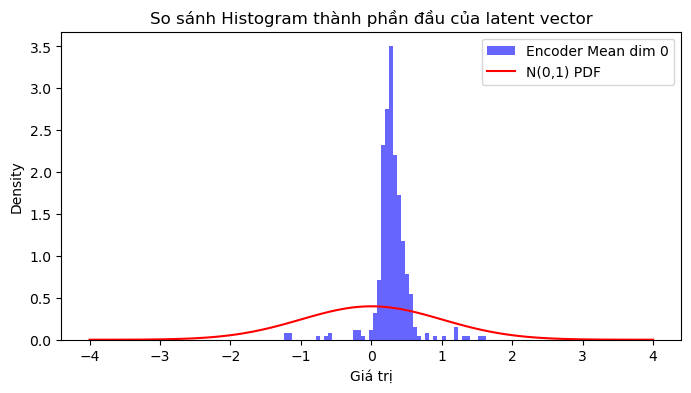

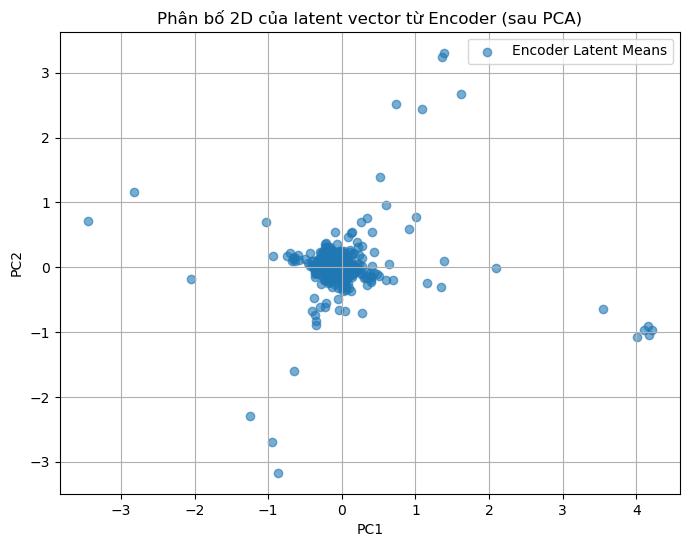

In [34]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Giả sử cvae_loaded là mô hình đã huấn luyện và test_loader có dữ liệu x và condition
means = []
with torch.no_grad():
    for x, condition in test_loader:
        # Lấy đầu ra từ encoder: sử dụng output "mean" của q(z|x)
        _, mean, _ = cvae_loaded(x, condition)
        means.append(mean)
        
means = torch.cat(means, dim=0).cpu().numpy()

# Vẽ histogram cho thành phần thứ 1 của vector mean
plt.figure(figsize=(8,4))
plt.hist(means[:, 0], bins=50, density=True, alpha=0.6, color='b', label='Encoder Mean dim 0')

# Vẽ thêm histogram của N(0,1)
x_vals = np.linspace(-4, 4, 100)
pdf = 1/np.sqrt(2*np.pi) * np.exp(-0.5 * x_vals**2)
plt.plot(x_vals, pdf, 'r-', label='N(0,1) PDF')
plt.title('So sánh Histogram thành phần đầu của latent vector')
plt.xlabel('Giá trị')
plt.ylabel('Density')
plt.legend()
plt.show()

# Hoặc dùng PCA để giảm chiều và scatter plot
pca = PCA(n_components=2)
means_2d = pca.fit_transform(means)

plt.figure(figsize=(8,6))
plt.scatter(means_2d[:, 0], means_2d[:, 1], alpha=0.6, label='Encoder Latent Means')
plt.title('Phân bố 2D của latent vector từ Encoder (sau PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


Average MSE on Test Set: 0.0012


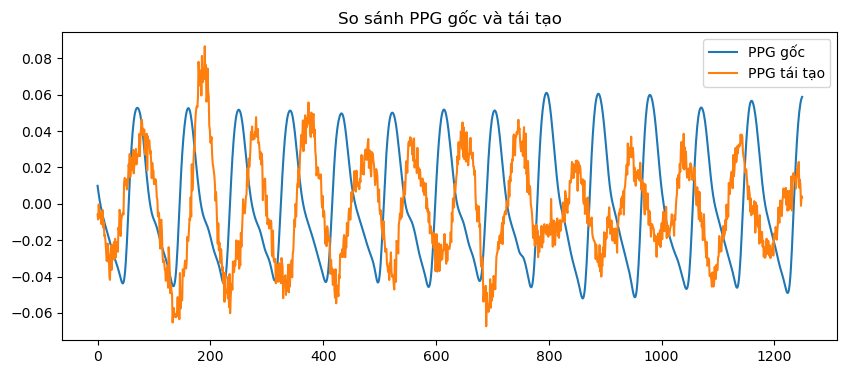

In [35]:
# Đánh giá trên tập test (MSE trung bình)
cvae_loaded.eval()
total_mse = 0
with torch.no_grad():
    for x, condition in test_loader:
        x_recon, _, _ = cvae_loaded(x, condition)
        mse = F.mse_loss(x_recon, x, reduction='mean')
        total_mse += mse.item()
avg_mse = total_mse / len(test_loader)
print(f"Average MSE on Test Set: {avg_mse:.4f}")

# So sánh PPG gốc và tái tạo
plt.figure(figsize=(10, 4))
plt.plot(X_test[0], label='PPG gốc')
plt.plot(x_recon[0].numpy(), label='PPG tái tạo')
plt.legend()
plt.title("So sánh PPG gốc và tái tạo")
plt.show()

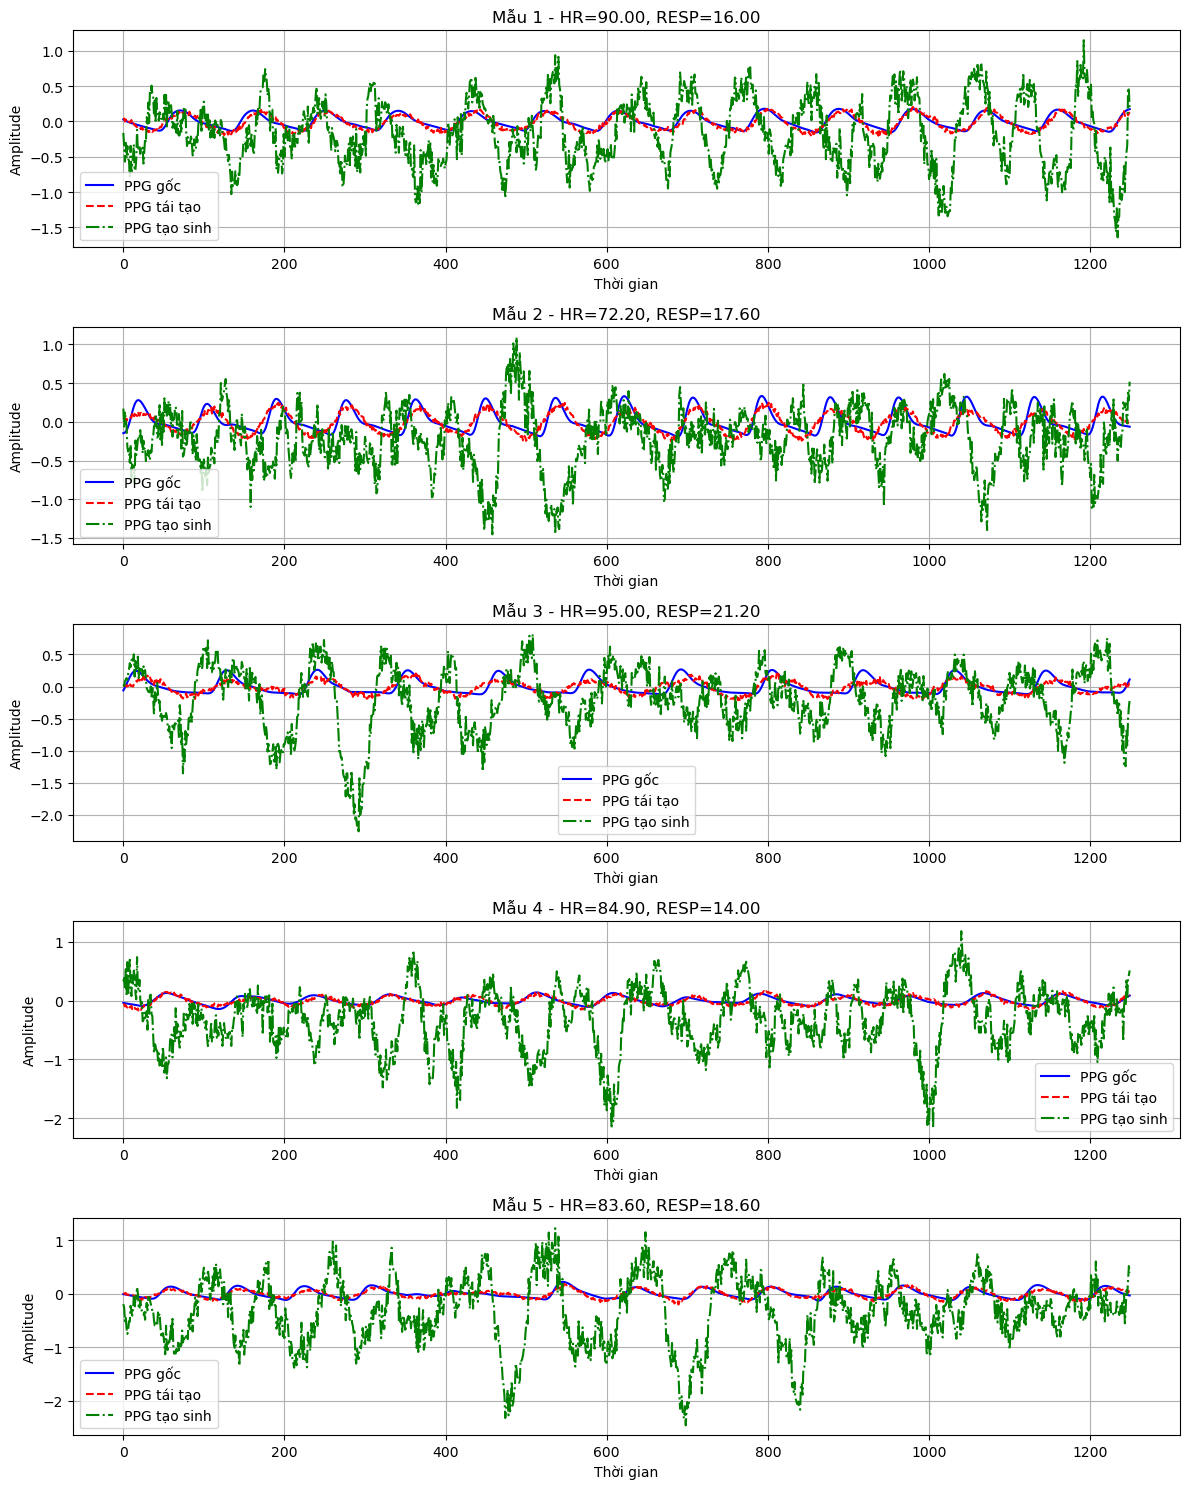

In [36]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Hàm inverse cho PPG:
# Dữ liệu PPG đã được chuẩn hóa bằng z_scaler và scale về [-1, 1] bằng cách chia cho pleth_max.
def inverse_scaler_ppg(x):
    # x: numpy array có shape (-1, 1)
    # Nhân với pleth_max để đưa về giá trị Z-score ban đầu, sau đó inverse với z_scaler
    return z_scaler.inverse_transform(x * pleth_max)

# Inverse transform điều kiện HR và RESP từ C_test_tensor (đã được chuẩn hóa bằng minmax_scaler)
# Giả sử C_test_tensor có 2 cột: HR_normalized và RESP_normalized.
conditions_denorm = minmax_scaler.inverse_transform(C_test_tensor.cpu().numpy())

# Số mẫu muốn hiển thị
num_samples = 5

# Lấy một số mẫu từ tập test
x_originals = X_test_tensor[:num_samples]
c_originals = C_test_tensor[:num_samples]

# Khởi tạo danh sách kết quả
x_recons = []
x_gens = []

# Đưa mô hình sang eval mode
cvae_loaded.eval()
with torch.no_grad():
    for i in range(num_samples):
        x = x_originals[i].unsqueeze(0)  # Thêm chiều batch
        c = c_originals[i].unsqueeze(0)

        # Tái tạo (reconstruction)
        x_recon, _, _ = cvae_loaded(x, c)
        # Chuyển về numpy, reshape và inverse transform PPG
        x_recon_np = x_recon[0].cpu().numpy().reshape(-1, 1)
        x_recon_denorm = inverse_scaler_ppg(x_recon_np).flatten()
        x_recons.append(x_recon_denorm)

        # Tạo latent vector ngẫu nhiên và tạo sinh (generation)
        z = torch.randn(1, latent_dim)
        x_gen = cvae_loaded.decoder(z, c)
        x_gen_np = x_gen[0].cpu().numpy().reshape(-1, 1)
        x_gen_denorm = inverse_scaler_ppg(x_gen_np).flatten()
        x_gens.append(x_gen_denorm)

# Inverse transform PPG gốc từ X_test_tensor (đã được chuẩn hóa)
x_originals_denorm = [inverse_scaler_ppg(x.reshape(-1, 1)).flatten() for x in x_originals.cpu().numpy()]

# Vẽ kết quả so sánh
plt.figure(figsize=(12, num_samples * 3))
for i in range(num_samples):
    # Lấy giá trị gốc của HR và RESP từ conditions_denorm
    hr, resp = conditions_denorm[i]
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(x_originals_denorm[i], label='PPG gốc', color='blue')
    plt.plot(x_recons[i], label='PPG tái tạo', color='red', linestyle='--')
    plt.plot(x_gens[i], label='PPG tạo sinh', color='green', linestyle='-.')
    plt.title(f'Mẫu {i+1} - HR={hr:.2f}, RESP={resp:.2f}')
    plt.xlabel('Thời gian')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


c:\Users\nguye\anaconda3\envs\inds_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


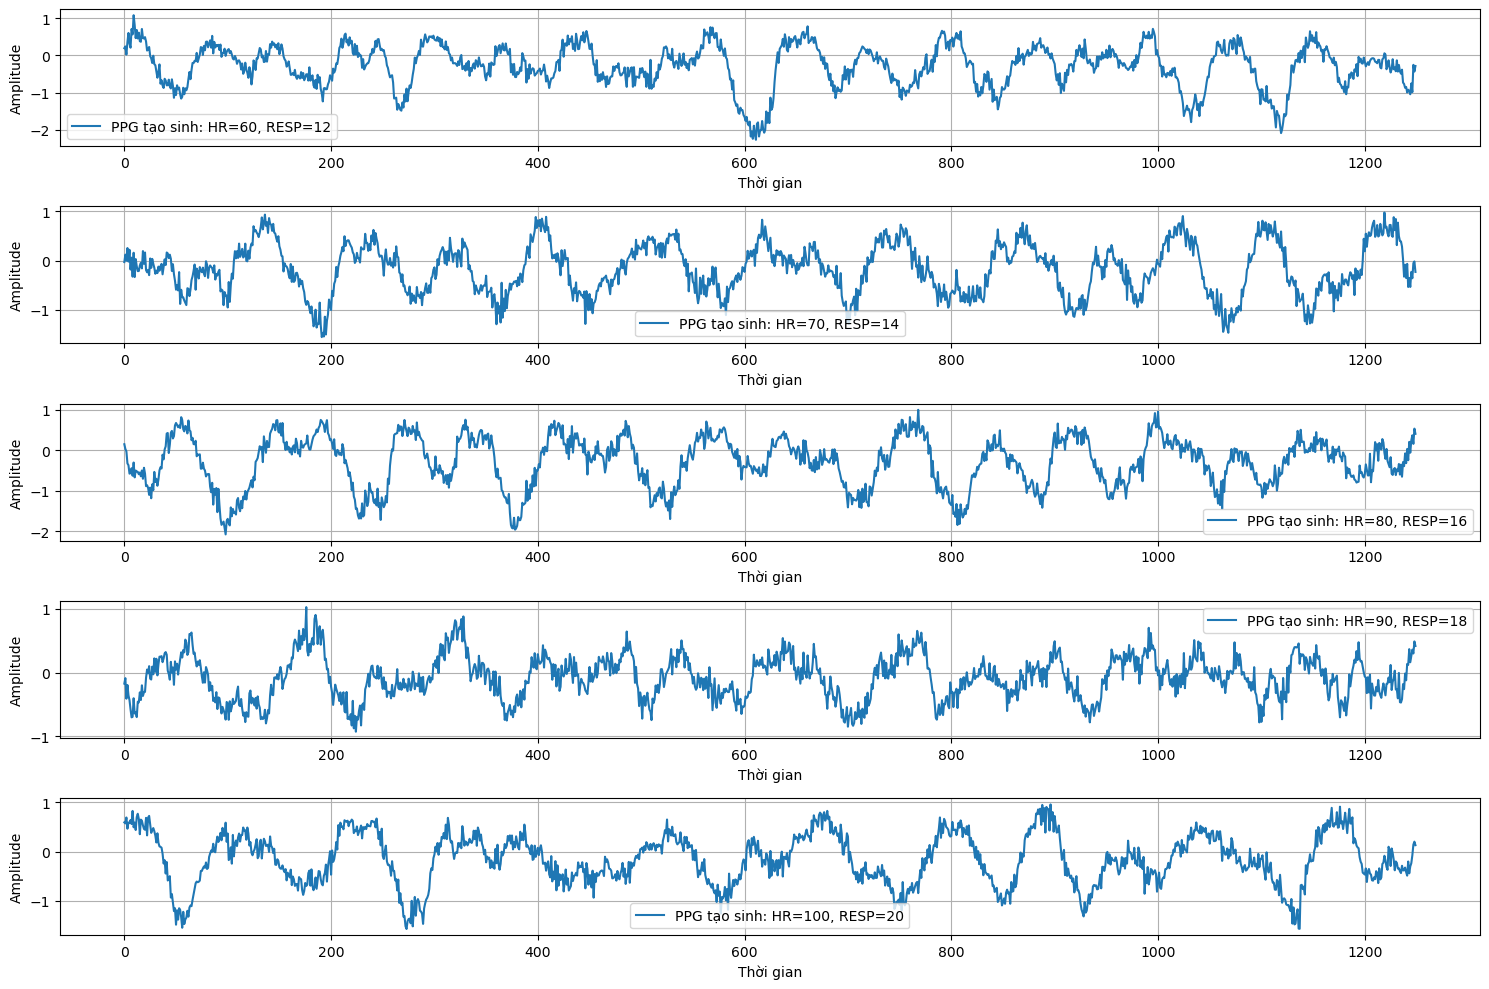

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Số mẫu PPG muốn tạo
num_generated = 5

# Tạo latent vector ngẫu nhiên
z = torch.randn(num_generated, latent_dim)

# Tạo điều kiện HR và RESP gốc (dữ liệu thô)
conditions_generated_raw = np.array([
    [60, 12],
    [70, 14],
    [80, 16],
    [90, 18],
    [100, 20]
])

# Chuẩn hóa điều kiện theo cùng scaler dùng khi train (dùng minmax_scaler)
conditions_generated_norm = minmax_scaler.transform(conditions_generated_raw)
conditions_generated = torch.FloatTensor(conditions_generated_norm)

# Sinh PPG mới từ mô hình CVAE
cvae_loaded.eval()
with torch.no_grad():
    ppg_generated = cvae_loaded.decoder(z, conditions_generated)

# Inverse transform PPG tạo sinh về giá trị gốc
ppg_generated_denorm = []
for i in range(num_generated):
    gen_sample = ppg_generated[i].cpu().numpy().reshape(-1, 1)
    gen_denorm = inverse_scaler_ppg(gen_sample).flatten()
    ppg_generated_denorm.append(gen_denorm)

# Vẽ kết quả
plt.figure(figsize=(15, 10))
for i in range(num_generated):
    hr, resp = conditions_generated_raw[i]
    plt.subplot(num_generated, 1, i+1)
    plt.plot(ppg_generated_denorm[i], label=f'PPG tạo sinh: HR={hr}, RESP={resp}')
    plt.xlabel('Thời gian')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
